<a href="https://colab.research.google.com/github/zera7654/02456-deep-learning-with-PyTorch/blob/master/final_pj2_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load Packages
from 4.2 CIFAR-10

In [1]:
!pip install tensorflow
!pip install tensorflow-datasets
!pip install tqdm

In [2]:
!pip install scipy

In [5]:
%matplotlib inline
import gc
from tqdm import tqdm
from scipy import linalg
import time
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import argparse
from torchvision.utils import make_grid
from sklearn import metrics
from typing import Optional, Tuple, Union, List
from torchvision.utils import save_image
import os
import math
sns.set_style("whitegrid")
from torchvision.models import inception_v3
import torch.utils.data

In [6]:
def gather(consts: torch.Tensor, t: torch.Tensor):
    """Gather consts for $t$ and reshape to feature map shape"""
    c = consts.gather(-1, t)
    return c.reshape(-1, 1, 1, 1)

# Experiments
We set T = 1000 for all experiments so that the number of neural network evaluations needed during sampling matches previous work [53, 55]. We set the forward process variances to constants increasing linearly from β1 = 10−4 to βT = 0.02. These constants were chosen to be small relative to data scaled to [−1, 1], ensuring that reverse and forward processes have approximately the same functional form while keeping the signal-to-noise ratio at xT as small as possible (LT = DKL(q(xT |x0) ‖ N (0, I)) ≈ 10−5 bits per dimension in our experiments).

In [7]:
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


class TimeEmbedding(nn.Module):


    def __init__(self, n_channels: int):

        super().__init__()
        self.n_channels = n_channels
        # First linear layer
        self.lin1 = nn.Linear(self.n_channels // 4, self.n_channels)
        # Activation
        self.act = Swish()
        # Second linear layer
        self.lin2 = nn.Linear(self.n_channels, self.n_channels)

    def forward(self, t: torch.Tensor):
        half_dim = self.n_channels // 8
        emb = math.log(10_000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=1)

        # Transform with the MLP
        emb = self.act(self.lin1(emb))
        emb = self.lin2(emb)

        #
        return emb


class ResidualBlock(nn.Module):

    def __init__(self, in_channels: int, out_channels: int, time_channels: int,
                 n_groups: int = 32, dropout: float = 0.1):
        super().__init__()
        self.norm1 = nn.GroupNorm(n_groups, in_channels)
        self.act1 = Swish()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))

        self.norm2 = nn.GroupNorm(n_groups, out_channels)
        self.act2 = Swish()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))

        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1))
        else:
            self.shortcut = nn.Identity()
        self.time_emb = nn.Linear(time_channels, out_channels)
        self.time_act = Swish()

        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        h = self.conv1(self.act1(self.norm1(x)))
        h += self.time_emb(self.time_act(t))[:, :, None, None]
        h = self.conv2(self.dropout(self.act2(self.norm2(h))))
        return h + self.shortcut(x)


class AttentionBlock(nn.Module):

    def __init__(self, n_channels: int, n_heads: int = 1, d_k: int = None, n_groups: int = 32):
        super().__init__()

        if d_k is None:
            d_k = n_channels
        self.norm = nn.GroupNorm(n_groups, n_channels)
        self.projection = nn.Linear(n_channels, n_heads * d_k * 3)
        self.output = nn.Linear(n_heads * d_k, n_channels)
        # Scale for dot-product attention
        self.scale = d_k ** -0.5
        #
        self.n_heads = n_heads
        self.d_k = d_k

    def forward(self, x: torch.Tensor, t: Optional[torch.Tensor] = None):
        _ = t
        batch_size, n_channels, height, width = x.shape

        x = x.view(batch_size, n_channels, -1).permute(0, 2, 1)

        qkv = self.projection(x).view(batch_size, -1, self.n_heads, 3 * self.d_k)

        q, k, v = torch.chunk(qkv, 3, dim=-1)

        attn = torch.einsum('bihd,bjhd->bijh', q, k) * self.scale
        attn = attn.softmax(dim=2)
        res = torch.einsum('bijh,bjhd->bihd', attn, v)
        res = res.view(batch_size, -1, self.n_heads * self.d_k)
        res = self.output(res)
        res += x

        res = res.permute(0, 2, 1).view(batch_size, n_channels, height, width)

        #
        return res


class DownBlock(nn.Module):

    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        self.res = ResidualBlock(in_channels, out_channels, time_channels)
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res(x, t)
        x = self.attn(x)
        return x


class UpBlock(nn.Module):

    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        # The input has `in_channels + out_channels` because we concatenate the output of the same resolution
        # from the first half of the U-Net
        self.res = ResidualBlock(in_channels + out_channels, out_channels, time_channels)
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res(x, t)
        x = self.attn(x)
        return x


class MiddleBlock(nn.Module):

    def __init__(self, n_channels: int, time_channels: int):
        super().__init__()
        self.res1 = ResidualBlock(n_channels, n_channels, time_channels)
        self.attn = AttentionBlock(n_channels)
        self.res2 = ResidualBlock(n_channels, n_channels, time_channels)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res1(x, t)
        x = self.attn(x)
        x = self.res2(x, t)
        return x


class Upsample(nn.Module):

    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.ConvTranspose2d(n_channels, n_channels, (4, 4), (2, 2), (1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        return self.conv(x)


class Downsample(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.Conv2d(n_channels, n_channels, (3, 3), (2, 2), (1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, image_channels: int = 3, n_channels: int = 64,
                 ch_mults: Union[Tuple[int, ...], List[int]] = (1, 2, 2, 4),
                 is_attn: Union[Tuple[bool, ...], List[bool]] = (False, False, True, True),
                 n_blocks: int = 2):
        super().__init__()
        n_resolutions = len(ch_mults)
        #这里我改过这一行
        self.image_channels = image_channels
        # Project image into feature map
        self.image_proj = nn.Conv2d(image_channels, n_channels, kernel_size=(3, 3), padding=(1, 1))

        # Time embedding layer. Time embedding has `n_channels * 4` channels
        self.time_emb = TimeEmbedding(n_channels * 4)
        down = []
        # Number of channels
        out_channels = in_channels = n_channels
        # For each resolution
        for i in range(n_resolutions):
            # Number of output channels at this resolution
            out_channels = in_channels * ch_mults[i]
            # Add `n_blocks`
            for _ in range(n_blocks):
                down.append(DownBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
                in_channels = out_channels
            # Down sample at all resolutions except the last
            if i < n_resolutions - 1:
                down.append(Downsample(in_channels))

        # Combine the set of modules
        self.down = nn.ModuleList(down)

        # Middle block
        self.middle = MiddleBlock(out_channels, n_channels * 4, )
        up = []
        # Number of channels
        in_channels = out_channels
        # For each resolution
        for i in reversed(range(n_resolutions)):
            # `n_blocks` at the same resolution
            out_channels = in_channels
            for _ in range(n_blocks):
                up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
            # Final block to reduce the number of channels
            out_channels = in_channels // ch_mults[i]

            up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
            in_channels = out_channels
            # Up sample at all resolutions except last
            if i > 0:
                up.append(Upsample(in_channels))

        # Combine the set of modules
        self.up = nn.ModuleList(up)

        # Final normalization and convolution layer
        self.norm = nn.GroupNorm(8, n_channels)
        self.act = Swish()
        self.final = nn.Conv2d(in_channels, image_channels, kernel_size=(3, 3), padding=(1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):

        # Get time-step embeddings
        t = self.time_emb(t)

        # Get image projection
        x = self.image_proj(x)

        # `h` will store outputs at each resolution for skip connection
        h = [x]
        # First half of U-Net
        for m in self.down:
            x = m(x, t)
            h.append(x)

        # Middle (bottom)
        x = self.middle(x, t)

        # Second half of U-Net
        for m in self.up:
            if isinstance(m, Upsample):
                x = m(x, t)
            else:
                # Get the skip connection from first half of U-Net and concatenate
                s = h.pop()
                x = torch.cat((x, s), dim=1)
                #
                x = m(x, t)

        # Final normalization and convolution
        return self.final(self.act(self.norm(x)))

In [8]:
class DenoiseDiffusion(nn.Module):
    def __init__(self, eps_model: nn.Module, n_steps: int, device: torch.device):
        """
        * `eps_model` is $\textcolor{lightgreen}{\epsilon_\theta}(x_t, t)$ model
        * `n_steps` is $t$
        * `device` is the device to place constants on
        """
        super().__init__()
        self.eps_model = eps_model
        self.beta = torch.linspace(0.0001, 0.02, n_steps).to(device)

        self.alpha = 1. - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.n_steps = n_steps

        # sigma^2 = beta
        self.sigma2 = self.beta

    def q_xt_x0(self, x0: torch.Tensor, t: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        mean = gather(self.alpha_bar, t) ** 0.5 * x0
        var = 1 - gather(self.alpha_bar, t)
        return mean, var


    def q_sample(self, x0: torch.Tensor, t: torch.Tensor, eps: Optional[torch.Tensor] = None):
        if eps is None:
            eps = torch.randn_like(x0)
        mean, var = self.q_xt_x0(x0, t)
        return mean + (var ** 0.5) * eps

    def p_sample(self, xt: torch.Tensor, t: torch.Tensor):

        eps_theta = self.eps_model(xt, t)
        # alpha_bar_t
        alpha_bar = gather(self.alpha_bar, t)
        # alpha_t
        alpha = gather(self.alpha, t)

        eps_coef = (1 - alpha) / (1 - alpha_bar) ** .5

        mean = 1 / (alpha ** 0.5) * (xt - eps_coef * eps_theta)
        # sigma^2
        var = gather(self.sigma2, t)

        # epsilon
        eps = torch.randn(xt.shape, device=xt.device)
        # Sample
        return mean + (var ** .5) * eps

    def loss(self, x0: torch.Tensor, noise: Optional[torch.Tensor] = None):

        # batch size
        batch_size = x0.shape[0]

        t = torch.randint(0, self.n_steps, (batch_size,), device=x0.device, dtype=torch.long)
        if noise is None:
            noise = torch.randn_like(x0)


        xt = self.q_sample(x0, t, eps=noise)
        eps_theta = self.eps_model(xt, t)
        return F.mse_loss(noise, eps_theta)

In [9]:
import tensorflow as tf

# GPU
if tf.test.gpu_device_name():
    print(f"GPU is available: {tf.test.gpu_device_name()}")
else:
    print("No GPU found!")

GPU is available: /device:GPU:0


In [10]:
def train_diffusion_model(diffusion: DenoiseDiffusion, dataloader: DataLoader, optimizer: optim.Optimizer, device: torch.device, epochs: int = 10):
    diffusion.train()
    for epoch in range(epochs):
        epoch_loss = 0.0
        for batch_ndx, batch in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")):
            x0, _ = batch
            x0 = x0.to(device)
            loss = diffusion.loss(x0)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            if batch_ndx % 100 == 0:
                print(f'Epoch [{epoch+1}/{epochs}] Step [{batch_ndx}/{len(dataloader)}], Loss: {loss.item():.4f}')

            # release storage
            del x0, loss
            torch.cuda.empty_cache()
            gc.collect()

        avg_loss = epoch_loss / len(dataloader)
        print(f"Epoch {epoch+1} Average Loss: {avg_loss:.4f}")

In [11]:
#FOR CIFAR-10
def sample_diffusion_model(diffusion: DenoiseDiffusion, num_samples: int, device: torch.device,num_steps_to_show):
    diffusion.eval()
    saved_steps = []  # save image in middle
    saved_steps_times = []  # save time steps

    with torch.no_grad():
        xt = torch.randn(num_samples, 3, 32, 32).to(device)
        step_interval = diffusion.n_steps // num_steps_to_show
        steps_to_save = set([diffusion.n_steps - i * step_interval for i in range(1, num_steps_to_show + 1)])
        steps_to_save.add(0)

        for t_ in tqdm(reversed(range(diffusion.n_steps)), desc="Sampling"):
            t = torch.full((num_samples,), t_, device=device, dtype=torch.long)
            xt = diffusion.p_sample(xt, t)

            if t_ in steps_to_save:
                saved_steps.append(xt[0].cpu().clone())
                saved_steps_times.append(t_)

            del t
            torch.cuda.empty_cache()
            gc.collect()

        final_images = xt.clamp(-1, 1)


    fig, axes = plt.subplots(1, num_steps_to_show, figsize=(num_steps_to_show * 2, 2))
    fig.suptitle("Progressive Generation")

    for idx, img in enumerate(saved_steps):
        img = img.permute(1, 2, 0).numpy()
        img = (img + 1) / 2
        img = (img * 255).astype(np.uint8)
        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(f"Step {saved_steps_times[idx]}")

    plt.tight_layout()
    plt.show()

    return final_images

In [12]:
# for MNIST
def sample_diffusion_model_2(diffusion: DenoiseDiffusion, num_samples: int, device: torch.device,num_steps_to_show: int = 10):
    diffusion.eval()
    saved_steps = []
    saved_steps_times = []
    with torch.no_grad():
        xt = torch.randn(num_samples, 1, 32, 32).to(device)

        step_interval = diffusion.n_steps // num_steps_to_show
        steps_to_save = set([diffusion.n_steps - i * step_interval for i in range(1, num_steps_to_show + 1)])
        steps_to_save.add(0)


        for t_ in tqdm(reversed(range(diffusion.n_steps)), desc="Sampling"):
            t = torch.full((num_samples,), t_, device=device, dtype=torch.long)
            xt = diffusion.p_sample(xt, t)

            if t_ in steps_to_save:
                saved_steps.append(xt[0].cpu().clone())
                saved_steps_times.append(t_)

            del t
            torch.cuda.empty_cache()
            gc.collect()

        final_images = xt.clamp(-1, 1)

    fig, axes = plt.subplots(1, num_steps_to_show, figsize=(num_steps_to_show * 2, 2))
    fig.suptitle("Progressive Generation")

    for idx, img in enumerate(saved_steps):
        img = img.squeeze().numpy()
        img = (img + 1) / 2
        axes[idx].imshow(img, cmap='gray')
        axes[idx].axis('off')
        axes[idx].set_title(f"Step {saved_steps_times[idx]}")

    plt.tight_layout()
    plt.show()

    return final_images

In [13]:
def calculate_fid(real_images, generated_images, batch_size=32, device='cuda'):
    preprocess = transforms.Compose([
        transforms.Resize((299, 299)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    inception = inception_v3(pretrained=True, transform_input=False).to(device)
    inception.eval()

    def get_features(x):
        features = []
        with torch.no_grad():
            dataset = TensorDataset(x)
            loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
            for batch in tqdm(loader, desc="提取特征"):
                batch = batch[0].to(device)
                batch = preprocess(batch)
                out = inception(batch).cpu().numpy()
                features.append(out)
        return np.concatenate(features, axis=0)

    real_features = get_features(real_images)
    gen_features = get_features(generated_images)

    mu1 = np.mean(real_features, axis=0)
    sigma1 = np.cov(real_features, rowvar=False)

    mu2 = np.mean(gen_features, axis=0)
    sigma2 = np.cov(gen_features, rowvar=False)

    diff = mu1 - mu2
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)

    return fid

In [14]:
# for MNIST dataset

def calculate_fid_2(real_images, generated_images, batch_size=32, device='cuda'):
    # Define preprocessing steps
    preprocess = transforms.Compose([
        transforms.Resize((299, 299)),                     # Resize to Inception v3 expected size
        transforms.Lambda(lambda x: x.repeat(3, 1, 1)),    # Convert 1 channel to 3 channels by repeating
        transforms.Normalize(mean=[0.485, 0.456, 0.406],   # Normalize as per Inception v3 requirements
                             std=[0.229, 0.224, 0.225])
    ])

    # Load pre-trained Inception v3 model
    inception = inception_v3(pretrained=True, transform_input=False).to(device)
    inception.eval()

    def get_features(x):
        features = []
        with torch.no_grad():
            dataset = TensorDataset(x)
            loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
            for batch in tqdm(loader, desc="Extracting features"):
                batch = batch[0].to(device).float()                 # Ensure tensor is float
                if batch.dim() == 3:
                    batch = batch.unsqueeze(1)                      # Add channel dimension if missing
                batch = preprocess(batch)                            # Apply preprocessing
                out = inception(batch)                              # Forward pass through Inception
                # If inception returns auxiliary outputs, take the main output
                if isinstance(out, tuple):
                    out = out[0]
                out = out.cpu().numpy()
                features.append(out)
        return np.concatenate(features, axis=0)

    # Extract features for real and generated images
    real_features = get_features(real_images)
    gen_features = get_features(generated_images)

    # Compute mean and covariance statistics
    mu1 = np.mean(real_features, axis=0)
    sigma1 = np.cov(real_features, rowvar=False)

    mu2 = np.mean(gen_features, axis=0)
    sigma2 = np.cov(gen_features, rowvar=False)

    # Compute FID
    diff = mu1 - mu2
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)

    return fid


In [15]:
#
n_channels = 64
channel_multipliers = [1, 2, 2, 4]
is_attention = [False, False, False, True]
n_steps = 1000
batch_size = 64
image_size = 32
learning_rate = 2e-5
n_samples = 16
epochs = 10  # 10 for MNIST 50 for CIFAR-10
    # 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [ ]:
#CIFAR-10
transform_train = transforms.Compose([
transforms.Resize((image_size, image_size)),
transforms.RandomHorizontalFlip(),                     # augmentation
transforms.ToTensor(),
transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


transform_test = transforms.Compose([
transforms.Resize((image_size, image_size)),
transforms.ToTensor(),
transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])



train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=True, pin_memory=True)

100%|██████████| 170M/170M [00:01<00:00, 95.9MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [16]:
# MNIST
transform_train = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # MNIST gray scale
])

transform_test = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


train_set = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform_train
)

test_set = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform_test
)


train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
    drop_last=True,
    pin_memory=True
)

test_loader = DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4,
    drop_last=True,
    pin_memory=True
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 43.9MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.19MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.8MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.99MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [24]:

unet = UNet(
    # image_channels=1,#MNIST
    image_channels=1,#CIFAR-10 use 3
    n_channels=n_channels,
    ch_mults=channel_multipliers,
    is_attn=is_attention,
    n_blocks=2
 ).to(device)

In [25]:

diffusion = DenoiseDiffusion(
    eps_model=unet,
    n_steps=n_steps,
    device=device
)

In [26]:

optimizer = optim.Adam(unet.parameters(), lr=learning_rate)

In [27]:

train_diffusion_model(diffusion, train_loader, optimizer, device, epochs=epochs)

Epoch 1/10:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch [1/10] Step [0/937], Loss: 0.9049


Epoch 1/10:  11%|█         | 100/937 [00:36<05:08,  2.71it/s]

Epoch [1/10] Step [100/937], Loss: 0.1431


Epoch 1/10:  21%|██▏       | 200/937 [01:11<04:12,  2.92it/s]

Epoch [1/10] Step [200/937], Loss: 0.1087


Epoch 1/10:  32%|███▏      | 300/937 [01:46<03:40,  2.89it/s]

Epoch [1/10] Step [300/937], Loss: 0.0881


Epoch 1/10:  43%|████▎     | 400/937 [02:20<03:06,  2.88it/s]

Epoch [1/10] Step [400/937], Loss: 0.0897


Epoch 1/10:  53%|█████▎    | 500/937 [02:55<02:31,  2.89it/s]

Epoch [1/10] Step [500/937], Loss: 0.0820


Epoch 1/10:  64%|██████▍   | 600/937 [03:29<01:54,  2.95it/s]

Epoch [1/10] Step [600/937], Loss: 0.0505


Epoch 1/10:  75%|███████▍  | 700/937 [04:04<01:21,  2.92it/s]

Epoch [1/10] Step [700/937], Loss: 0.0470


Epoch 1/10:  85%|████████▌ | 800/937 [04:38<00:47,  2.87it/s]

Epoch [1/10] Step [800/937], Loss: 0.0690


Epoch 1/10:  96%|█████████▌| 900/937 [05:13<00:12,  2.92it/s]

Epoch [1/10] Step [900/937], Loss: 0.0446


Epoch 1/10: 100%|██████████| 937/937 [05:26<00:00,  2.87it/s]


Epoch 1 Average Loss: 0.0901


Epoch 2/10:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch [2/10] Step [0/937], Loss: 0.0356


Epoch 2/10:  11%|█         | 100/937 [00:35<05:07,  2.72it/s]

Epoch [2/10] Step [100/937], Loss: 0.0436


Epoch 2/10:  21%|██▏       | 200/937 [01:10<04:17,  2.86it/s]

Epoch [2/10] Step [200/937], Loss: 0.0448


Epoch 2/10:  32%|███▏      | 300/937 [01:46<03:44,  2.83it/s]

Epoch [2/10] Step [300/937], Loss: 0.0387


Epoch 2/10:  43%|████▎     | 400/937 [02:21<03:13,  2.78it/s]

Epoch [2/10] Step [400/937], Loss: 0.0371


Epoch 2/10:  53%|█████▎    | 500/937 [02:56<02:34,  2.83it/s]

Epoch [2/10] Step [500/937], Loss: 0.0225


Epoch 2/10:  64%|██████▍   | 600/937 [03:32<02:01,  2.78it/s]

Epoch [2/10] Step [600/937], Loss: 0.0358


Epoch 2/10:  75%|███████▍  | 700/937 [04:09<01:26,  2.73it/s]

Epoch [2/10] Step [700/937], Loss: 0.0284


Epoch 2/10:  85%|████████▌ | 800/937 [04:45<00:49,  2.78it/s]

Epoch [2/10] Step [800/937], Loss: 0.0239


Epoch 2/10:  96%|█████████▌| 900/937 [05:21<00:13,  2.76it/s]

Epoch [2/10] Step [900/937], Loss: 0.0253


Epoch 2/10: 100%|██████████| 937/937 [05:35<00:00,  2.79it/s]


Epoch 2 Average Loss: 0.0353


Epoch 3/10:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch [3/10] Step [0/937], Loss: 0.0255


Epoch 3/10:  11%|█         | 100/937 [00:36<04:54,  2.84it/s]

Epoch [3/10] Step [100/937], Loss: 0.0279


Epoch 3/10:  21%|██▏       | 200/937 [01:11<04:22,  2.81it/s]

Epoch [3/10] Step [200/937], Loss: 0.0236


Epoch 3/10:  32%|███▏      | 300/937 [01:46<03:43,  2.85it/s]

Epoch [3/10] Step [300/937], Loss: 0.0319


Epoch 3/10:  43%|████▎     | 400/937 [02:21<03:05,  2.89it/s]

Epoch [3/10] Step [400/937], Loss: 0.0288


Epoch 3/10:  53%|█████▎    | 500/937 [02:56<02:30,  2.91it/s]

Epoch [3/10] Step [500/937], Loss: 0.0329


Epoch 3/10:  64%|██████▍   | 600/937 [03:31<01:56,  2.89it/s]

Epoch [3/10] Step [600/937], Loss: 0.0247


Epoch 3/10:  75%|███████▍  | 700/937 [04:06<01:23,  2.83it/s]

Epoch [3/10] Step [700/937], Loss: 0.0205


Epoch 3/10:  85%|████████▌ | 800/937 [04:41<00:48,  2.85it/s]

Epoch [3/10] Step [800/937], Loss: 0.0261


Epoch 3/10:  96%|█████████▌| 900/937 [05:16<00:12,  2.91it/s]

Epoch [3/10] Step [900/937], Loss: 0.0266


Epoch 3/10: 100%|██████████| 937/937 [05:29<00:00,  2.84it/s]


Epoch 3 Average Loss: 0.0289


Epoch 4/10:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch [4/10] Step [0/937], Loss: 0.0303


Epoch 4/10:  11%|█         | 100/937 [00:36<04:59,  2.79it/s]

Epoch [4/10] Step [100/937], Loss: 0.0315


Epoch 4/10:  21%|██▏       | 200/937 [01:11<04:16,  2.87it/s]

Epoch [4/10] Step [200/937], Loss: 0.0245


Epoch 4/10:  32%|███▏      | 300/937 [01:46<03:46,  2.82it/s]

Epoch [4/10] Step [300/937], Loss: 0.0256


Epoch 4/10:  43%|████▎     | 400/937 [02:22<03:12,  2.79it/s]

Epoch [4/10] Step [400/937], Loss: 0.0252


Epoch 4/10:  53%|█████▎    | 500/937 [02:58<02:36,  2.80it/s]

Epoch [4/10] Step [500/937], Loss: 0.0261


Epoch 4/10:  64%|██████▍   | 600/937 [03:33<01:58,  2.85it/s]

Epoch [4/10] Step [600/937], Loss: 0.0185


Epoch 4/10:  75%|███████▍  | 700/937 [04:08<01:24,  2.80it/s]

Epoch [4/10] Step [700/937], Loss: 0.0192


Epoch 4/10:  85%|████████▌ | 800/937 [04:44<00:48,  2.85it/s]

Epoch [4/10] Step [800/937], Loss: 0.0237


Epoch 4/10:  96%|█████████▌| 900/937 [05:19<00:13,  2.84it/s]

Epoch [4/10] Step [900/937], Loss: 0.0203


Epoch 4/10: 100%|██████████| 937/937 [05:33<00:00,  2.81it/s]


Epoch 4 Average Loss: 0.0256


Epoch 5/10:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch [5/10] Step [0/937], Loss: 0.0204


Epoch 5/10:  11%|█         | 100/937 [00:35<04:57,  2.82it/s]

Epoch [5/10] Step [100/937], Loss: 0.0273


Epoch 5/10:  21%|██▏       | 200/937 [01:10<04:16,  2.87it/s]

Epoch [5/10] Step [200/937], Loss: 0.0194


Epoch 5/10:  32%|███▏      | 300/937 [01:45<03:53,  2.73it/s]

Epoch [5/10] Step [300/937], Loss: 0.0263


Epoch 5/10:  43%|████▎     | 400/937 [02:20<03:05,  2.89it/s]

Epoch [5/10] Step [400/937], Loss: 0.0233


Epoch 5/10:  53%|█████▎    | 500/937 [02:55<02:31,  2.88it/s]

Epoch [5/10] Step [500/937], Loss: 0.0178


Epoch 5/10:  64%|██████▍   | 600/937 [03:30<02:01,  2.77it/s]

Epoch [5/10] Step [600/937], Loss: 0.0259


Epoch 5/10:  75%|███████▍  | 700/937 [04:05<01:21,  2.90it/s]

Epoch [5/10] Step [700/937], Loss: 0.0261


Epoch 5/10:  85%|████████▌ | 800/937 [04:41<00:47,  2.90it/s]

Epoch [5/10] Step [800/937], Loss: 0.0282


Epoch 5/10:  96%|█████████▌| 900/937 [05:16<00:13,  2.81it/s]

Epoch [5/10] Step [900/937], Loss: 0.0361


Epoch 5/10: 100%|██████████| 937/937 [05:29<00:00,  2.85it/s]


Epoch 5 Average Loss: 0.0237


Epoch 6/10:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch [6/10] Step [0/937], Loss: 0.0165


Epoch 6/10:  11%|█         | 100/937 [00:35<04:54,  2.84it/s]

Epoch [6/10] Step [100/937], Loss: 0.0232


Epoch 6/10:  21%|██▏       | 200/937 [01:11<04:21,  2.82it/s]

Epoch [6/10] Step [200/937], Loss: 0.0191


Epoch 6/10:  32%|███▏      | 300/937 [01:46<03:48,  2.78it/s]

Epoch [6/10] Step [300/937], Loss: 0.0193


Epoch 6/10:  43%|████▎     | 400/937 [02:21<03:08,  2.85it/s]

Epoch [6/10] Step [400/937], Loss: 0.0156


Epoch 6/10:  53%|█████▎    | 500/937 [02:57<02:33,  2.85it/s]

Epoch [6/10] Step [500/937], Loss: 0.0262


Epoch 6/10:  64%|██████▍   | 600/937 [03:32<01:58,  2.85it/s]

Epoch [6/10] Step [600/937], Loss: 0.0182


Epoch 6/10:  75%|███████▍  | 700/937 [04:08<01:25,  2.76it/s]

Epoch [6/10] Step [700/937], Loss: 0.0246


Epoch 6/10:  85%|████████▌ | 800/937 [04:43<00:48,  2.82it/s]

Epoch [6/10] Step [800/937], Loss: 0.0156


Epoch 6/10:  96%|█████████▌| 900/937 [05:18<00:12,  2.85it/s]

Epoch [6/10] Step [900/937], Loss: 0.0260


Epoch 6/10: 100%|██████████| 937/937 [05:31<00:00,  2.82it/s]


Epoch 6 Average Loss: 0.0223


Epoch 7/10:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch [7/10] Step [0/937], Loss: 0.0405


Epoch 7/10:  11%|█         | 100/937 [00:35<04:52,  2.86it/s]

Epoch [7/10] Step [100/937], Loss: 0.0177


Epoch 7/10:  21%|██▏       | 200/937 [01:10<04:16,  2.87it/s]

Epoch [7/10] Step [200/937], Loss: 0.0253


Epoch 7/10:  32%|███▏      | 300/937 [01:45<03:40,  2.88it/s]

Epoch [7/10] Step [300/937], Loss: 0.0188


Epoch 7/10:  43%|████▎     | 400/937 [02:20<03:09,  2.84it/s]

Epoch [7/10] Step [400/937], Loss: 0.0207


Epoch 7/10:  53%|█████▎    | 500/937 [02:55<02:34,  2.83it/s]

Epoch [7/10] Step [500/937], Loss: 0.0132


Epoch 7/10:  64%|██████▍   | 600/937 [03:30<02:02,  2.76it/s]

Epoch [7/10] Step [600/937], Loss: 0.0178


Epoch 7/10:  75%|███████▍  | 700/937 [04:07<01:22,  2.86it/s]

Epoch [7/10] Step [700/937], Loss: 0.0279


Epoch 7/10:  85%|████████▌ | 800/937 [04:42<00:47,  2.86it/s]

Epoch [7/10] Step [800/937], Loss: 0.0148


Epoch 7/10:  96%|█████████▌| 900/937 [05:17<00:12,  2.86it/s]

Epoch [7/10] Step [900/937], Loss: 0.0242


Epoch 7/10: 100%|██████████| 937/937 [05:30<00:00,  2.83it/s]


Epoch 7 Average Loss: 0.0214


Epoch 8/10:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch [8/10] Step [0/937], Loss: 0.0145


Epoch 8/10:  11%|█         | 100/937 [00:37<05:13,  2.67it/s]

Epoch [8/10] Step [100/937], Loss: 0.0169


Epoch 8/10:  21%|██▏       | 200/937 [01:15<04:35,  2.68it/s]

Epoch [8/10] Step [200/937], Loss: 0.0226


Epoch 8/10:  32%|███▏      | 300/937 [01:52<03:59,  2.66it/s]

Epoch [8/10] Step [300/937], Loss: 0.0256


Epoch 8/10:  43%|████▎     | 400/937 [02:30<03:17,  2.72it/s]

Epoch [8/10] Step [400/937], Loss: 0.0200


Epoch 8/10:  53%|█████▎    | 500/937 [03:07<02:45,  2.63it/s]

Epoch [8/10] Step [500/937], Loss: 0.0249


Epoch 8/10:  64%|██████▍   | 600/937 [03:44<02:04,  2.71it/s]

Epoch [8/10] Step [600/937], Loss: 0.0207


Epoch 8/10:  75%|███████▍  | 700/937 [04:20<01:28,  2.67it/s]

Epoch [8/10] Step [700/937], Loss: 0.0161


Epoch 8/10:  85%|████████▌ | 800/937 [04:56<00:47,  2.88it/s]

Epoch [8/10] Step [800/937], Loss: 0.0239


Epoch 8/10:  96%|█████████▌| 900/937 [05:32<00:13,  2.78it/s]

Epoch [8/10] Step [900/937], Loss: 0.0202


Epoch 8/10: 100%|██████████| 937/937 [05:45<00:00,  2.71it/s]


Epoch 8 Average Loss: 0.0202


Epoch 9/10:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch [9/10] Step [0/937], Loss: 0.0220


Epoch 9/10:  11%|█         | 100/937 [00:36<04:59,  2.79it/s]

Epoch [9/10] Step [100/937], Loss: 0.0186


Epoch 9/10:  21%|██▏       | 200/937 [01:13<04:29,  2.74it/s]

Epoch [9/10] Step [200/937], Loss: 0.0146


Epoch 9/10:  32%|███▏      | 300/937 [01:50<03:55,  2.70it/s]

Epoch [9/10] Step [300/937], Loss: 0.0237


Epoch 9/10:  43%|████▎     | 400/937 [02:27<03:21,  2.67it/s]

Epoch [9/10] Step [400/937], Loss: 0.0195


Epoch 9/10:  53%|█████▎    | 500/937 [03:04<02:41,  2.71it/s]

Epoch [9/10] Step [500/937], Loss: 0.0161


Epoch 9/10:  64%|██████▍   | 600/937 [03:41<01:59,  2.81it/s]

Epoch [9/10] Step [600/937], Loss: 0.0182


Epoch 9/10:  75%|███████▍  | 700/937 [04:17<01:25,  2.77it/s]

Epoch [9/10] Step [700/937], Loss: 0.0194


Epoch 9/10:  85%|████████▌ | 800/937 [04:53<00:50,  2.73it/s]

Epoch [9/10] Step [800/937], Loss: 0.0244


Epoch 9/10:  96%|█████████▌| 900/937 [05:29<00:13,  2.75it/s]

Epoch [9/10] Step [900/937], Loss: 0.0161


Epoch 9/10: 100%|██████████| 937/937 [05:43<00:00,  2.73it/s]


Epoch 9 Average Loss: 0.0199


Epoch 10/10:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch [10/10] Step [0/937], Loss: 0.0141


Epoch 10/10:  11%|█         | 100/937 [00:36<05:08,  2.71it/s]

Epoch [10/10] Step [100/937], Loss: 0.0230


Epoch 10/10:  21%|██▏       | 200/937 [01:12<04:24,  2.78it/s]

Epoch [10/10] Step [200/937], Loss: 0.0216


Epoch 10/10:  32%|███▏      | 300/937 [01:49<03:48,  2.79it/s]

Epoch [10/10] Step [300/937], Loss: 0.0196


Epoch 10/10:  43%|████▎     | 400/937 [02:24<03:09,  2.83it/s]

Epoch [10/10] Step [400/937], Loss: 0.0231


Epoch 10/10:  53%|█████▎    | 500/937 [03:00<02:35,  2.81it/s]

Epoch [10/10] Step [500/937], Loss: 0.0233


Epoch 10/10:  64%|██████▍   | 600/937 [03:37<02:01,  2.78it/s]

Epoch [10/10] Step [600/937], Loss: 0.0172


Epoch 10/10:  75%|███████▍  | 700/937 [04:13<01:23,  2.82it/s]

Epoch [10/10] Step [700/937], Loss: 0.0196


Epoch 10/10:  85%|████████▌ | 800/937 [04:49<00:50,  2.71it/s]

Epoch [10/10] Step [800/937], Loss: 0.0184


Epoch 10/10:  96%|█████████▌| 900/937 [05:25<00:13,  2.78it/s]

Epoch [10/10] Step [900/937], Loss: 0.0231


Epoch 10/10: 100%|██████████| 937/937 [05:38<00:00,  2.77it/s]

Epoch 10 Average Loss: 0.0195


Sampling: 1000it [04:42,  3.54it/s]


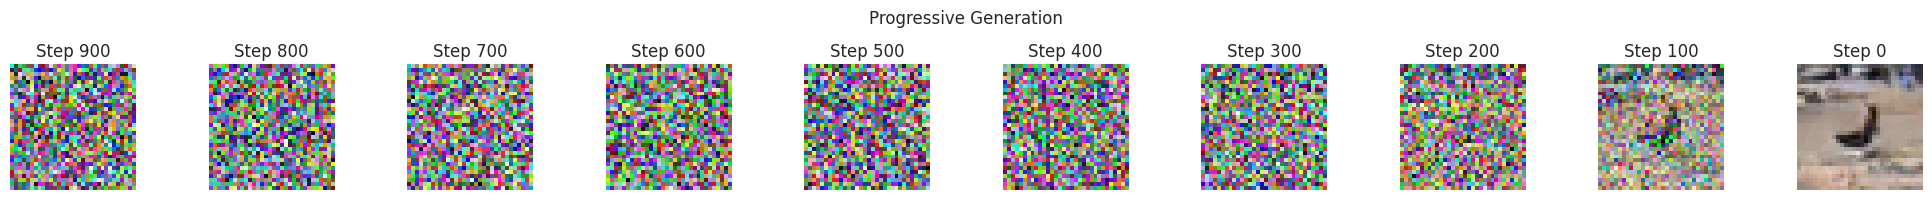

Saved 16 samples to 'outputs'.


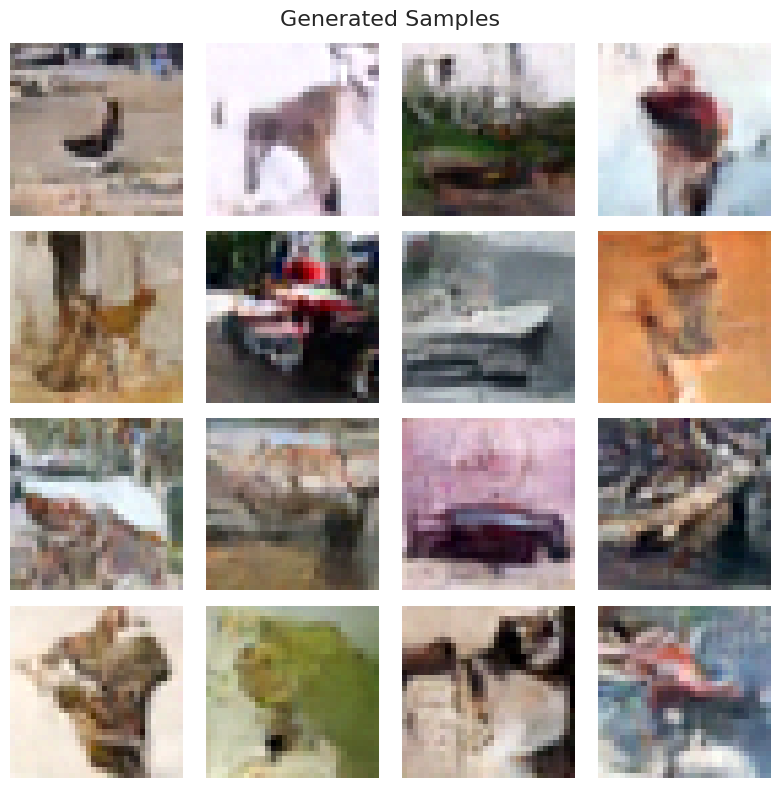

In [ ]:
# 采样生成图像

#when CIFAR use model, when MNIST use _2
generated_images = sample_diffusion_model(diffusion, n_samples, device,10)# for CIFAR-10

# 将生成的图像保存
output_dir = "outputs"
os.makedirs(output_dir, exist_ok=True)
for idx in range(n_samples):
    sample = generated_images[idx]
    save_image(sample * 0.5 + 0.5, os.path.join(output_dir, f'sample_{idx}.png'))  # 将[-1,1]映射回[0,1]
print(f"Saved {n_samples} samples to '{output_dir}'.")
# 可视化 16 个样本，按 4x4 网格显示
n_rows, n_cols = 4, 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 8))
fig.suptitle("Generated Samples", fontsize=16)

# 绘制每个样本 CIFAR-10
for idx, ax in enumerate(axes.flatten()):
    if idx < n_samples:
        img = generated_images[idx].permute(1, 2, 0).cpu().numpy()  # (C, H, W) -> (H, W, C)
        img = (img + 1) / 2  # 将 [-1, 1] 映射回 [0, 1]
        ax.imshow(img)
        ax.axis('off')
    else:
        ax.axis('off')  # 多余的网格不显示

plt.tight_layout()
plt.show()


Sampling: 1000it [05:01,  3.32it/s]


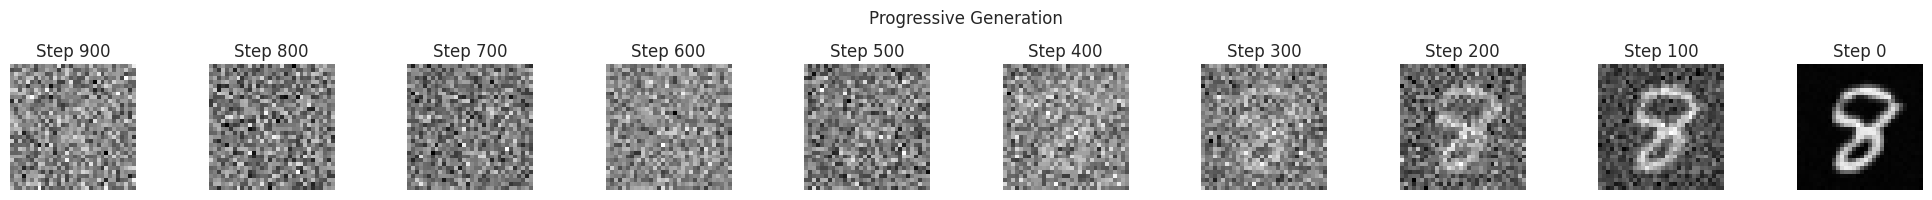

Saved 16 samples to 'outputs'.


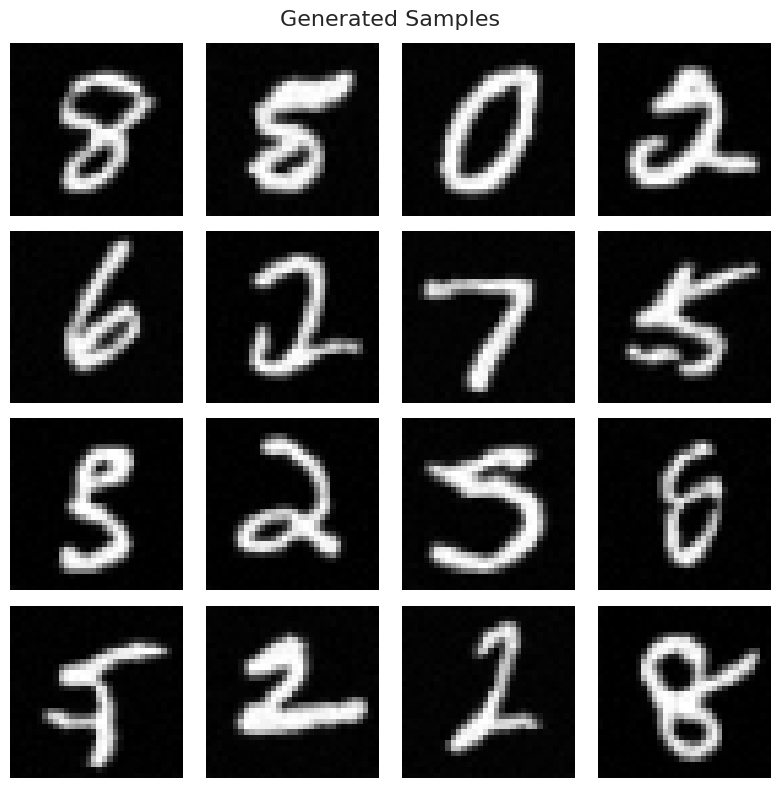

In [ ]:
generated_images = sample_diffusion_model_2(diffusion, n_samples, device,10)# FOR MNIST

# 将生成的图像保存
output_dir = "outputs"
os.makedirs(output_dir, exist_ok=True)
for idx in range(n_samples):
    sample = generated_images[idx]
    save_image(sample * 0.5 + 0.5, os.path.join(output_dir, f'sample_{idx}.png'))  # 将[-1,1]映射回[0,1]
print(f"Saved {n_samples} samples to '{output_dir}'.")
# 可视化 16 个样本，按 4x4 网格显示
n_rows, n_cols = 4, 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 8))
fig.suptitle("Generated Samples", fontsize=16)
# 绘制样本，MNIST
for idx, ax in enumerate(axes.flatten()):
    if idx < n_samples:
        img = generated_images[idx].squeeze().cpu().numpy()  # 去掉 (1, H, W) 的通道维度
        img = (img + 1) / 2  # 将 [-1, 1] 映射回 [0, 1]
        ax.imshow(img, cmap='gray')  # 确保灰度图显示
        ax.axis('off')
    else:
        ax.axis('off')  # 多余的网格不显示

plt.tight_layout()
plt.show()